Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libgl1-mesa-glx
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 5,584 B of archives.
After this operation, 74.8 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libgl1-mesa-glx amd64 23.0.4-0ubuntu1~22.04.1 [5,584 B]
Fetched 5,584 B in 0s (17.2 kB/s)
Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Setting up libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Extracting frames from video...
Extracted 30 frames


100%|██████████| 30/30 [08:31<00:00, 17.06s/it]


PSNR Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                   psnr   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1285.
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           2.80e-71
Time:                        04:26:58   Log-Likelihood:                -51.084
No. Observations:                  90   AIC:                             110.2
Df Residuals:                      86   BIC:                             120.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

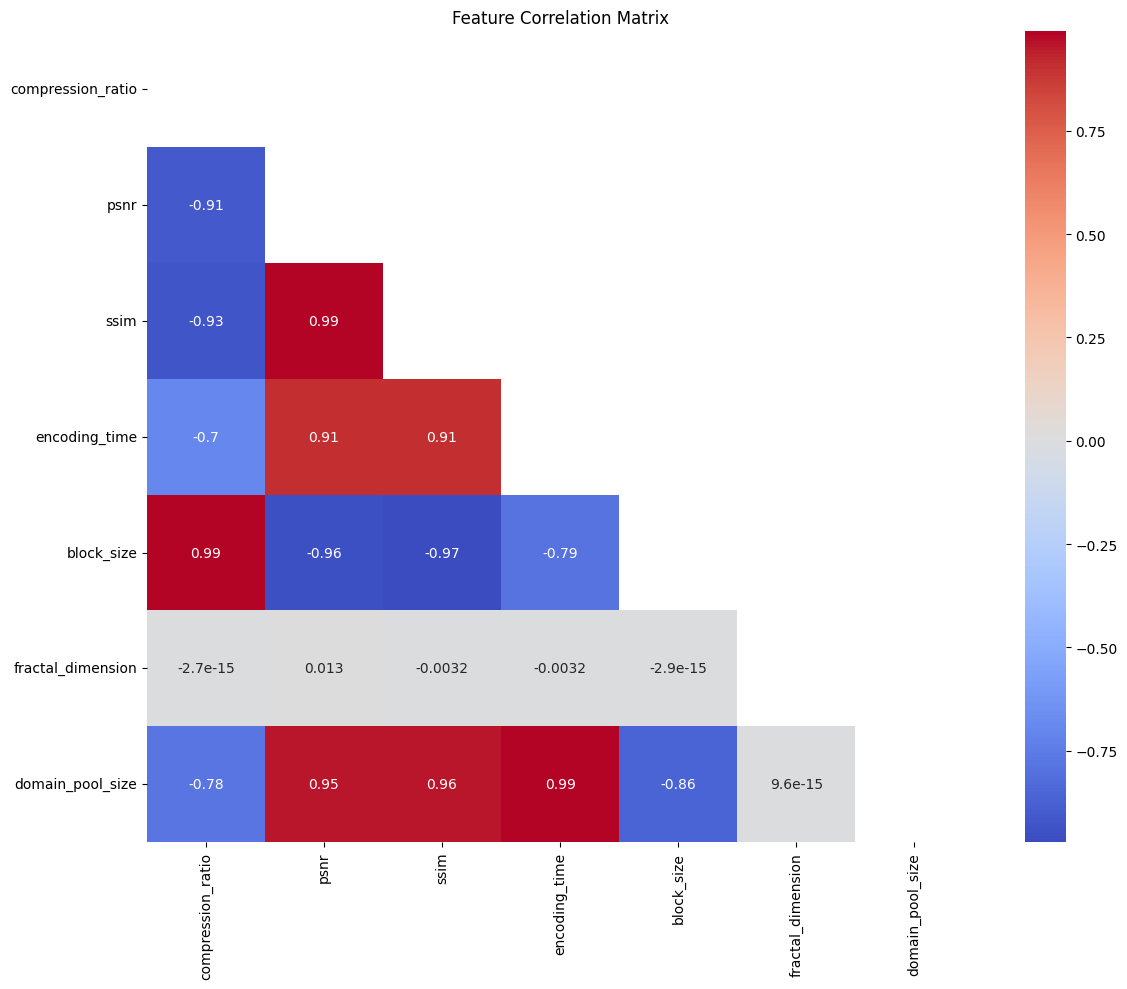

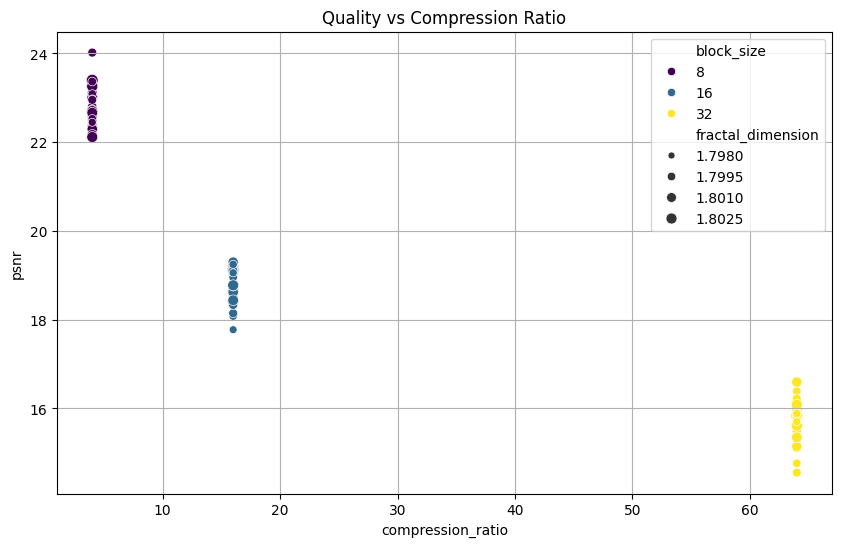

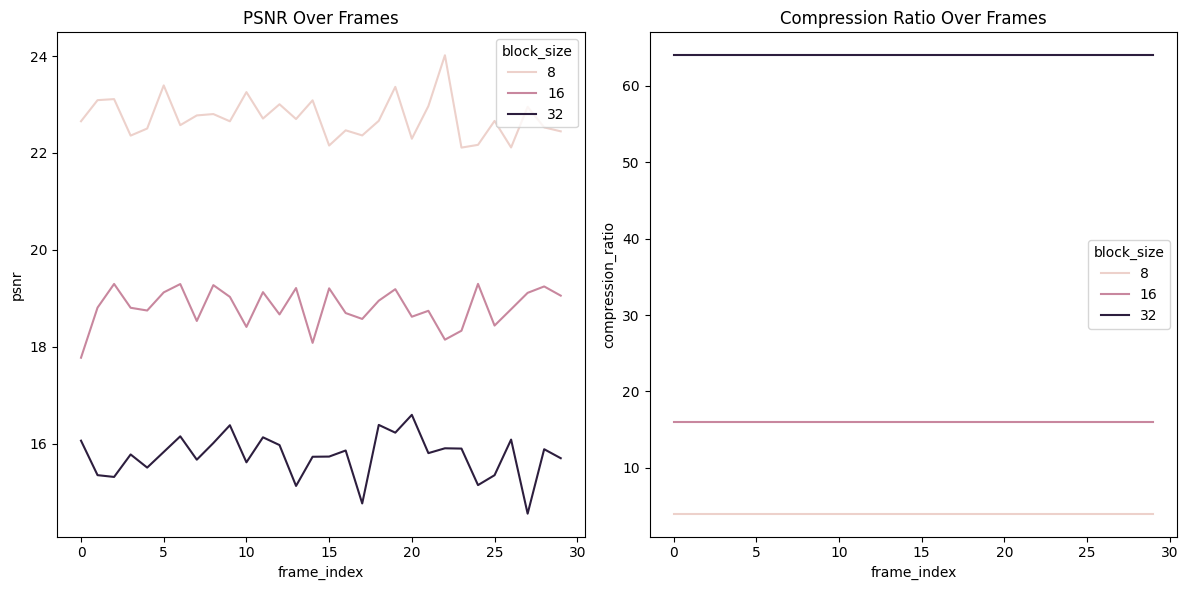

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tqdm import tqdm
import time
from skimage.metrics import peak_signal_noise_ratio as psnr_func
from skimage.metrics import structural_similarity as ssim_func
from scipy.stats import pearsonr
import sys
import statsmodels.api as sm
from google.colab import files

# Set random seed for reproducibility
np.random.seed(42)

# --- Section 1: Data Preparation ---
def prepare_video_data():
    """Download and prepare sample video frames."""
    # Install OpenGL library for Colab
    if "google.colab" in sys.modules:
        !apt-get install -y libgl1-mesa-glx

    # Download sample video
    !wget -q https://github.com/intel-iot-devkit/sample-videos/raw/master/classroom.mp4

    # Extract frames
    cap = cv2.VideoCapture("classroom.mp4")
    frame_count = 0
    all_frames = []

    print("Extracting frames from video...")
    while cap.isOpened() and frame_count < 30:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (256, 256))
        all_frames.append(resized)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames")
    return all_frames

# --- Section 2: Fractal Compression Implementation ---
class FractalCompression:
    def __init__(self, block_sizes=[8, 16, 32]):
        self.block_sizes = block_sizes
        self.results = {
            'frame_index': [], 'block_size': [],
            'compression_ratio': [], 'psnr': [],
            'ssim': [], 'encoding_time': [],
            'fractal_dimension': [], 'domain_pool_size': []
        }

    def estimate_fractal_dimension(self, image):
        """Estimate fractal dimension using box-counting method."""
        _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        scales = [2, 4, 8, 16]
        counts = []

        for scale in scales:
            count = 0
            for i in range(0, binary.shape[0], scale):
                for j in range(0, binary.shape[1], scale):
                    if np.sum(binary[i:i+scale, j:j+scale]) > 0:
                        count += 1
            counts.append(count)

        coeffs = np.polyfit(np.log(scales), np.log(counts), 1)
        return -coeffs[0]

    def compress_frame(self, frame, block_size):
        """Fractal compression implementation."""
        h, w = frame.shape
        start_time = time.time()
        domain_size = block_size * 2
        domain_pool = []

        # Build domain pool
        for i in range(0, h-domain_size+1, domain_size//2):
            for j in range(0, w-domain_size+1, domain_size//2):
                domain_block = frame[i:i+domain_size, j:j+domain_size]
                domain_pool.append(cv2.resize(domain_block, (block_size, block_size)))

        compressed = np.zeros_like(frame)

        # Process range blocks
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                if i+block_size > h or j+block_size > w:
                    continue

                range_block = frame[i:i+block_size, j:j+block_size]
                best_mse = float('inf')
                best_domain = None

                # Sample domains for efficiency
                for domain in random.sample(domain_pool, max(1, len(domain_pool)//5)):
                    domain_mean = np.mean(domain)
                    range_mean = np.mean(range_block)
                    covariance = np.mean((domain - domain_mean) * (range_block - range_mean))
                    dom_var = np.var(domain)

                    scale = covariance / dom_var if dom_var != 0 else 0
                    scale = np.clip(scale, -1, 1)
                    offset = range_mean - scale * domain_mean
                    transformed = scale * domain + offset

                    mse = np.mean((range_block - transformed) ** 2)
                    if mse < best_mse:
                        best_mse = mse
                        best_domain = transformed

                if best_domain is not None:
                    compressed[i:i+block_size, j:j+block_size] = best_domain

        # Calculate metrics
        encoding_time = time.time() - start_time
        original_size = frame.size * frame.itemsize
        compressed_size = (h//block_size) * (w//block_size) * 4 * 4  # 4 params per block
        compression_ratio = original_size / compressed_size if compressed_size > 0 else 0

        return {
            'compressed_frame': compressed,
            'compression_ratio': compression_ratio,
            'psnr': psnr_func(frame, compressed),
            'ssim': ssim_func(frame, compressed),
            'encoding_time': encoding_time,
            'domain_pool_size': len(domain_pool)
        }

    def process_frames(self, frames):
        """Process all frames with different block sizes."""
        for frame_idx, frame in enumerate(tqdm(frames)):
            fractal_dim = self.estimate_fractal_dimension(frame)

            for block_size in self.block_sizes:
                result = self.compress_frame(frame, block_size)
                self.results['frame_index'].append(frame_idx)
                self.results['block_size'].append(block_size)
                for metric in ['compression_ratio', 'psnr', 'ssim', 'encoding_time', 'domain_pool_size']:
                    self.results[metric].append(result[metric])
                self.results['fractal_dimension'].append(fractal_dim)

        return pd.DataFrame(self.results)

# --- Section 3: Visualization & Analysis ---
def analyze_results(df):
    """Generate comprehensive visualizations."""
    # Correlation Heatmap
    plt.figure(figsize=(12,10))
    corr_matrix = df[['compression_ratio', 'psnr', 'ssim', 'encoding_time',
                     'block_size', 'fractal_dimension', 'domain_pool_size']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=np.triu(corr_matrix))
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')

    # Quality vs Compression
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='compression_ratio', y='psnr', hue='block_size',
                   size='fractal_dimension', palette='viridis')
    plt.title("Quality vs Compression Ratio")
    plt.grid(True)
    plt.savefig('quality_vs_compression.png')

    # Temporal Analysis
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.lineplot(data=df, x='frame_index', y='psnr', hue='block_size')
    plt.title("PSNR Over Frames")

    plt.subplot(1,2,2)
    sns.lineplot(data=df, x='frame_index', y='compression_ratio', hue='block_size')
    plt.title("Compression Ratio Over Frames")
    plt.tight_layout()
    plt.savefig('temporal_analysis.png')

    # Regression Analysis
    X = sm.add_constant(df[['block_size', 'fractal_dimension', 'domain_pool_size']])
    model = sm.OLS(df['psnr'], X).fit()
    print("PSNR Regression Summary:")
    print(model.summary())

# --- Section 4: Main Execution ---
def main():
    # Prepare data
    frames = prepare_video_data()

    # Process frames
    compressor = FractalCompression(block_sizes=[8, 16, 32])
    results_df = compressor.process_frames(frames[:30])  # Use first 30 frames

    # Analyze results
    analyze_results(results_df)

    # Download results
    if "google.colab" in sys.modules:
        for fig in ['correlation_heatmap.png', 'quality_vs_compression.png', 'temporal_analysis.png']:
            files.download(fig)
        results_df.to_csv('results.csv', index=False)
        files.download('results.csv')

if __name__ == "__main__":
    main()


   frame_index  block_size  compression_ratio       psnr      ssim  \
0            0           8                4.0  22.655194  0.802831   
1            0          16               16.0  17.774272  0.552566   
2            0          32               64.0  16.061891  0.353284   
3            1           8                4.0  23.090744  0.809507   
4            1          16               16.0  18.808723  0.563247   

   encoding_time  fractal_dimension  domain_pool_size  
0      15.843574           1.798823               961  
1       1.567898           1.798823               225  
2       0.102332           1.798823                49  
3      15.616076           1.801120               961  
4       1.075406           1.801120               225  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   frame_index        90 non-null     int64

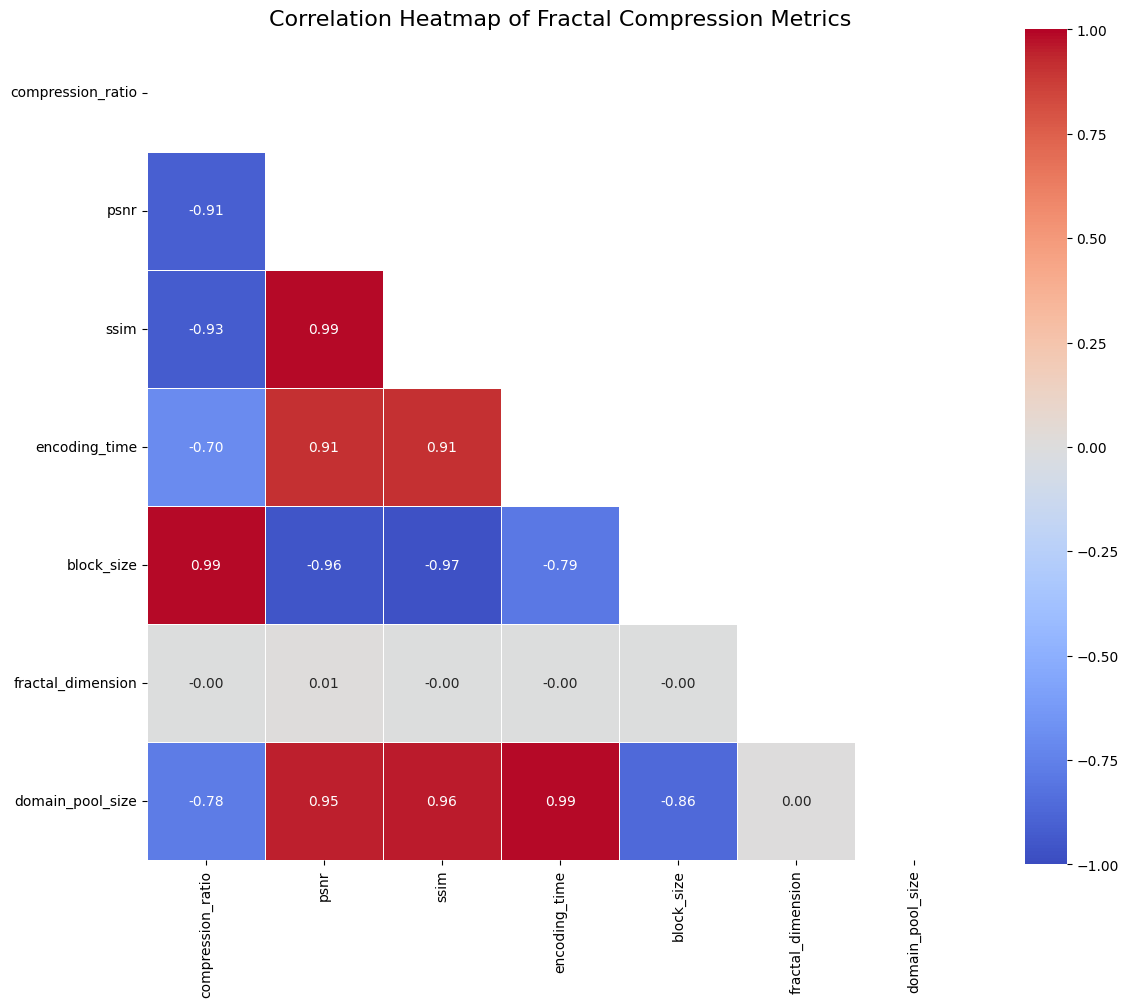

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/

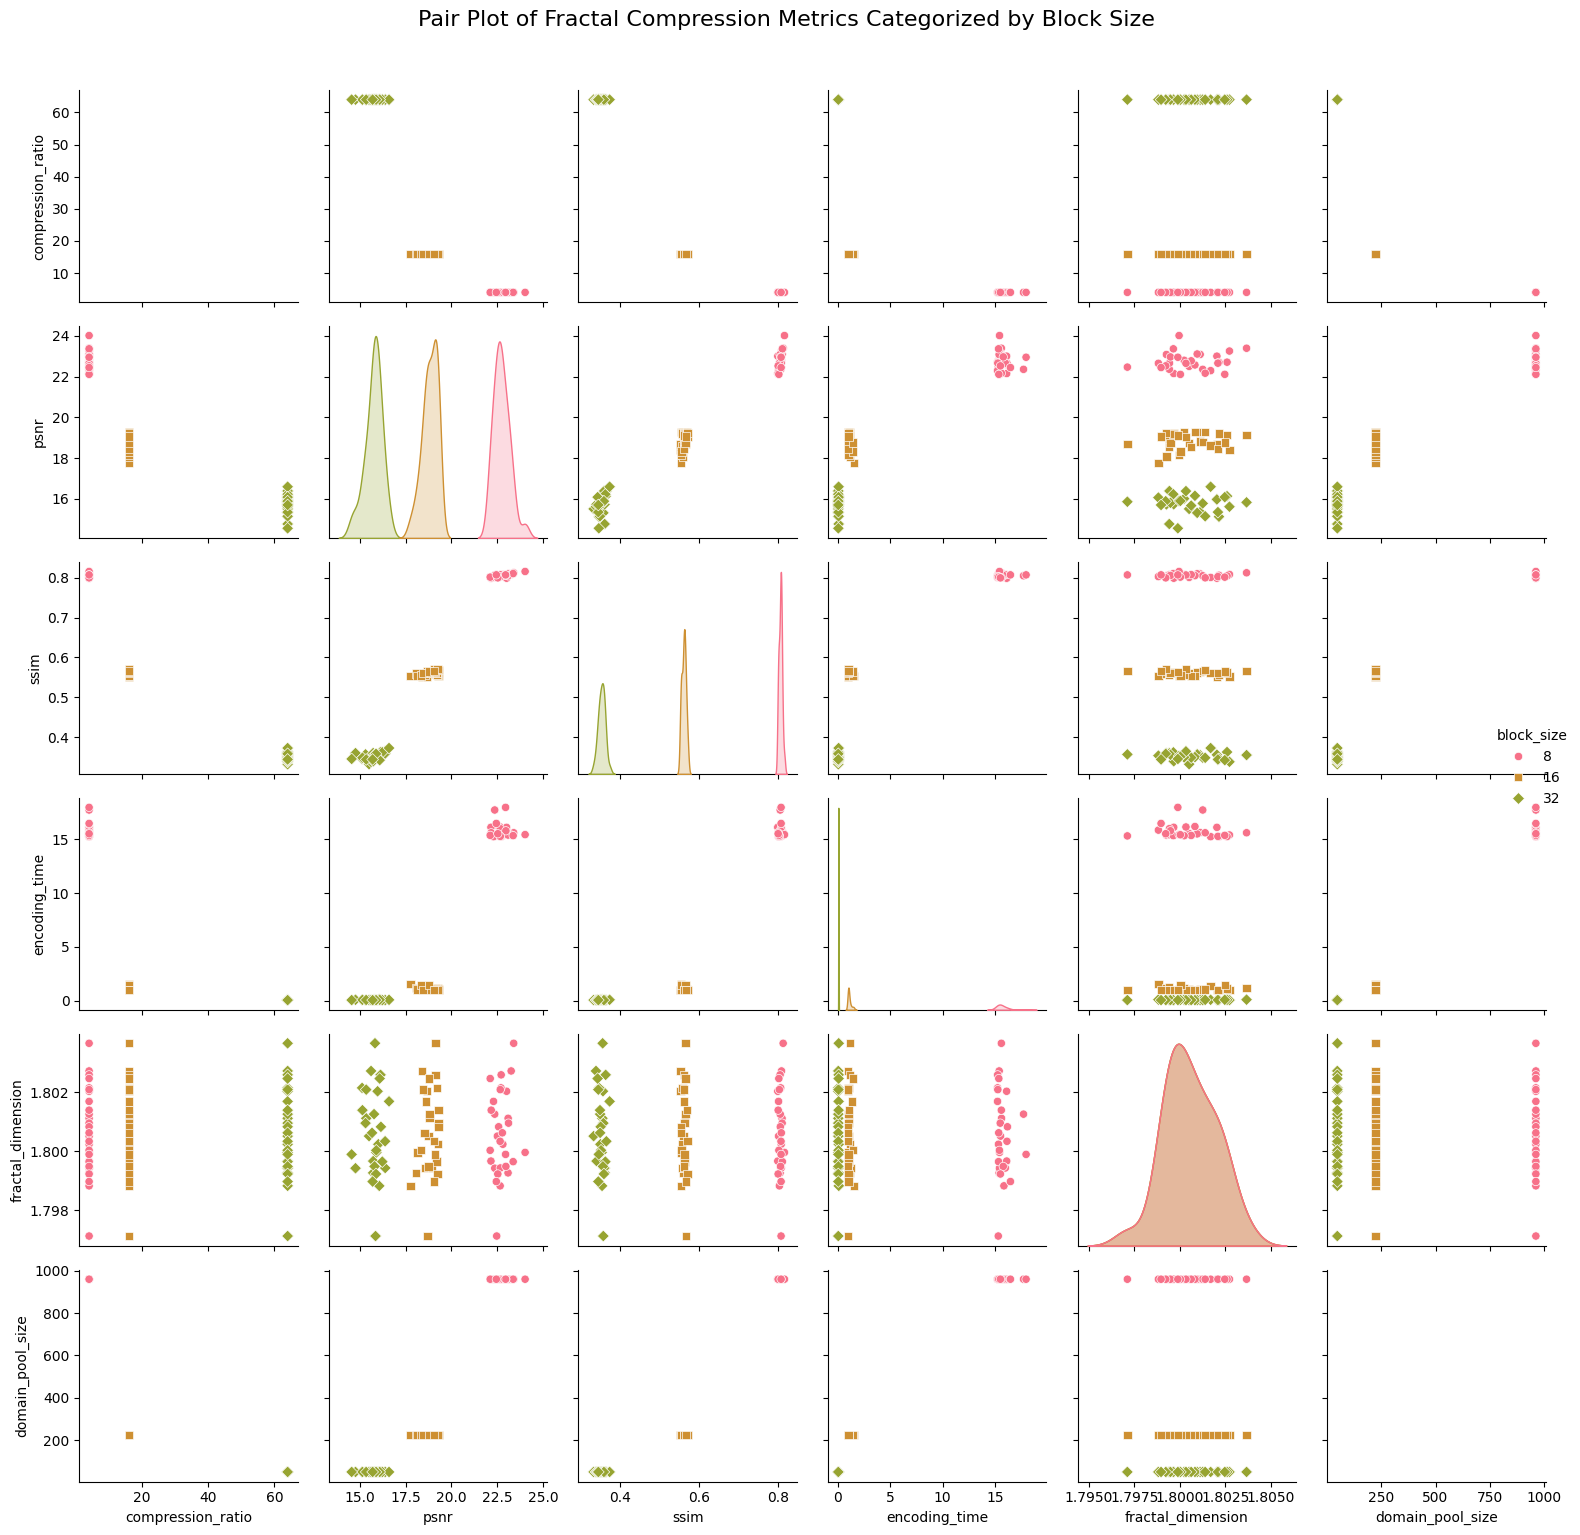

<ipython-input-6-5a7ea962031f>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='block_size', y='compression_ratio', data=results_df, palette="Set2")


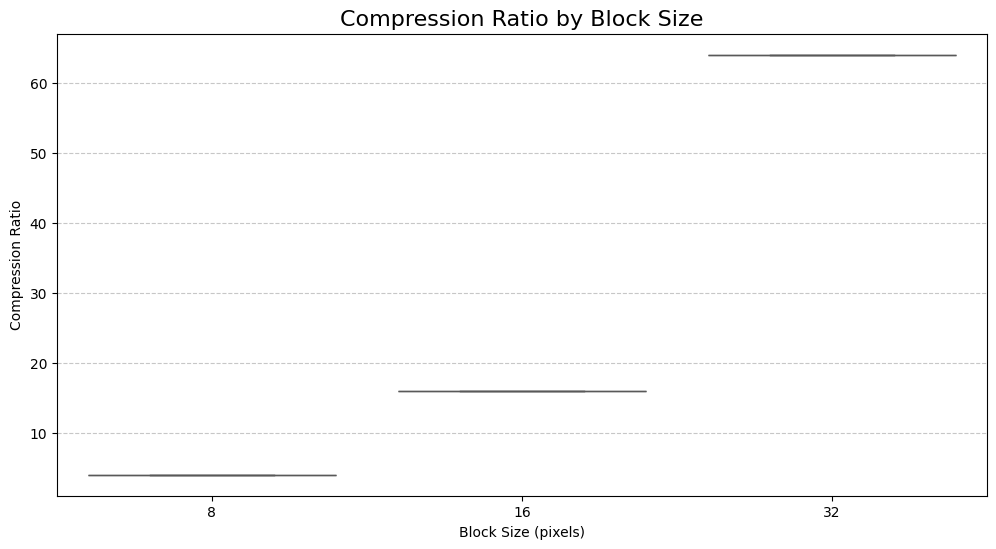

<ipython-input-6-5a7ea962031f>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='block_size', y='psnr', data=results_df, palette="Set3")
<ipython-input-6-5a7ea962031f>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='block_size', y='ssim', data=results_df, palette="Set3")


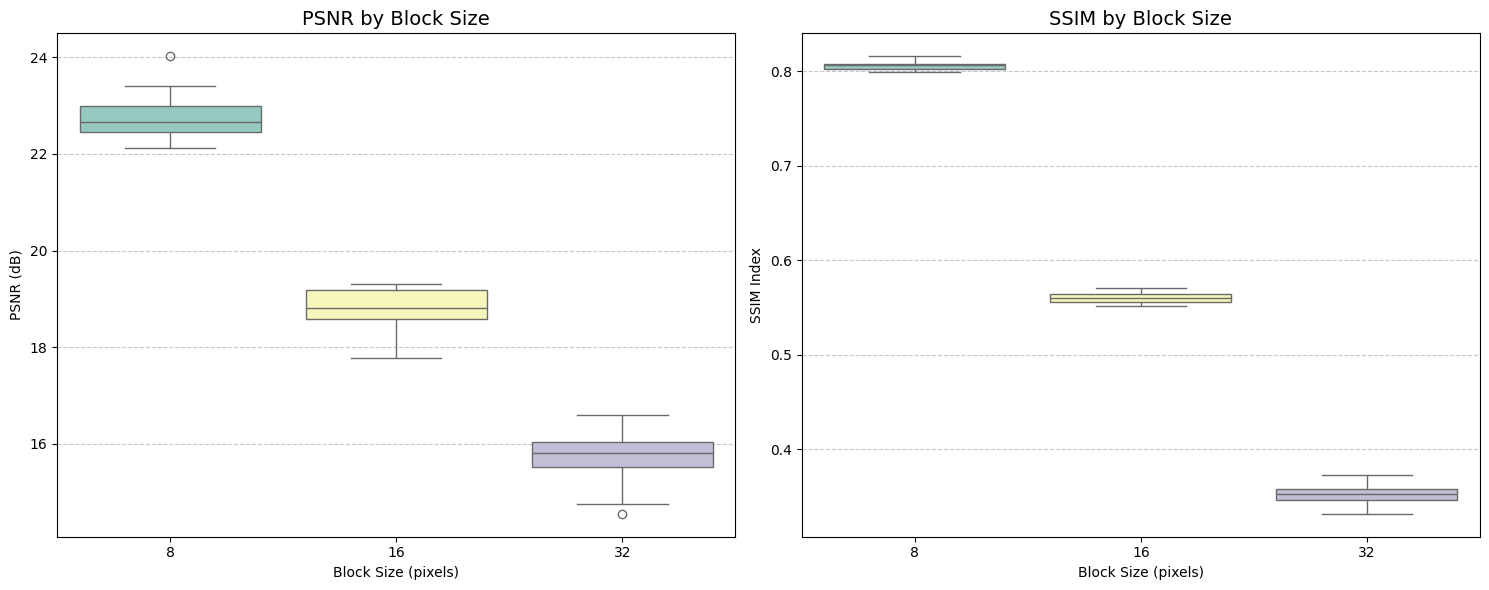

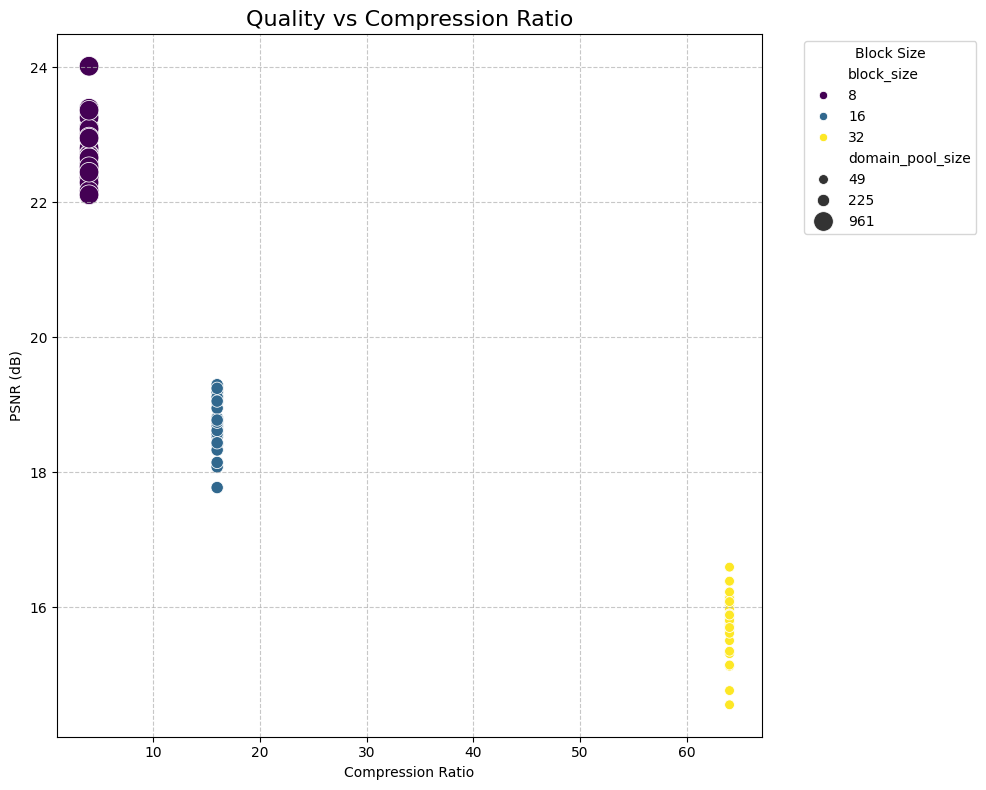

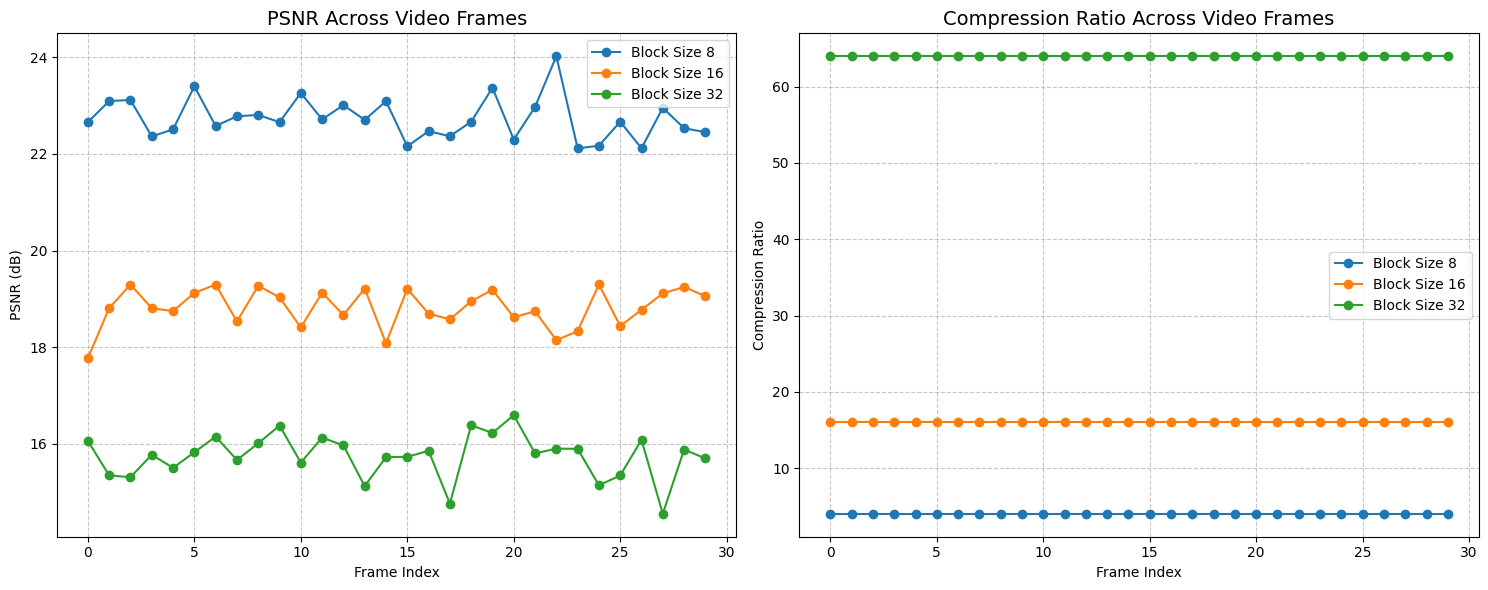

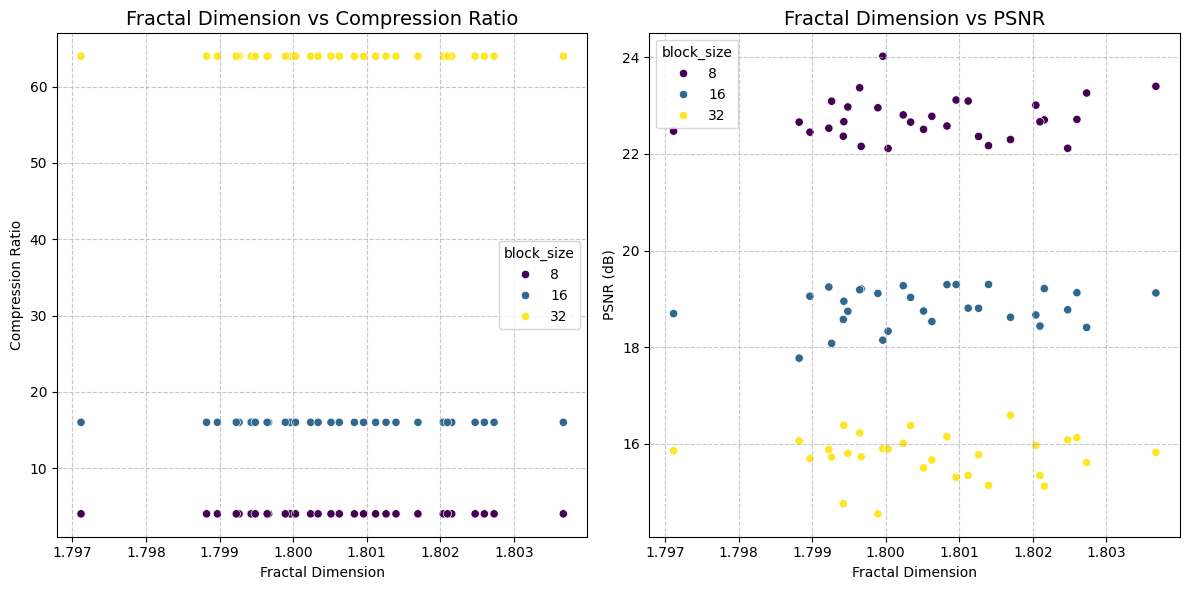

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results from the CSV file
results_df = pd.read_csv('results.csv')

# Inspect the DataFrame (optional)
print(results_df.head())
print(results_df.info())

# --- Visualization Section ---

# 1. **Correlation Heatmap**
plt.figure(figsize=(12, 10))
corr_columns = [
    'compression_ratio', 'psnr', 'ssim',
    'encoding_time', 'block_size',
    'fractal_dimension', 'domain_pool_size'
]
corr_matrix = results_df[corr_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
    vmin=-1, vmax=1, center=0, square=True, linewidths=.5
)
plt.title("Correlation Heatmap of Fractal Compression Metrics", fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

# 2. **Pair Plot**
sns.pairplot(
    results_df,
    vars=[
        'compression_ratio', 'psnr', 'ssim',
        'encoding_time', 'fractal_dimension', 'domain_pool_size'
    ],
    hue='block_size',
    palette=sns.color_palette("husl", 8),
    diag_kind='kde',
    markers=['o', 's', 'D']
)
plt.suptitle("Pair Plot of Fractal Compression Metrics Categorized by Block Size", y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig('pair_plot.png', dpi=300)
plt.show()

# 3. **Box Plot: Compression Ratio by Block Size**
plt.figure(figsize=(12, 6))
sns.boxplot(x='block_size', y='compression_ratio', data=results_df, palette="Set2")
plt.title("Compression Ratio by Block Size", fontsize=16)
plt.xlabel("Block Size (pixels)")
plt.ylabel("Compression Ratio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('compression_ratio_by_block_size.png', dpi=300)
plt.show()

# 4. **Box Plot: Quality Metrics by Block Size**
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='block_size', y='psnr', data=results_df, palette="Set3")
plt.title("PSNR by Block Size", fontsize=14)
plt.xlabel("Block Size (pixels)")
plt.ylabel("PSNR (dB)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.boxplot(x='block_size', y='ssim', data=results_df, palette="Set3")
plt.title("SSIM by Block Size", fontsize=14)
plt.xlabel("Block Size (pixels)")
plt.ylabel("SSIM Index")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('quality_metrics_by_block_size.png', dpi=300)
plt.show()

# 5. **Scatter Plot: Quality vs Compression Ratio**
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=results_df,
    x='compression_ratio',
    y='psnr',
    hue='block_size',
    size='domain_pool_size',
    sizes=(50, 200),
    palette='viridis'
)
plt.title("Quality vs Compression Ratio", fontsize=16)
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR (dB)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Block Size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('quality_vs_compression.png', dpi=300)
plt.show()

# 6. **Line Plot: Frame-by-Frame Analysis**
plt.figure(figsize=(15, 6))

# PSNR over frames
plt.subplot(1, 2, 1)
for block_size in results_df['block_size'].unique():
    block_data = results_df[results_df['block_size'] == block_size]
    plt.plot(block_data['frame_index'], block_data['psnr'], marker='o', linestyle='-', label=f'Block Size {block_size}')

plt.title("PSNR Across Video Frames", fontsize=14)
plt.xlabel("Frame Index")
plt.ylabel("PSNR (dB)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Compression ratio over frames
plt.subplot(1, 2, 2)
for block_size in results_df['block_size'].unique():
    block_data = results_df[results_df['block_size'] == block_size]
    plt.plot(block_data['frame_index'], block_data['compression_ratio'], marker='o', linestyle='-', label=f'Block Size {block_size}')

plt.title("Compression Ratio Across Video Frames", fontsize=14)
plt.xlabel("Frame Index")
plt.ylabel("Compression Ratio")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('frame_analysis.png', dpi=300)
plt.show()

# 7. **Scatter Plot: Fractal Dimension Impact**
plt.figure(figsize=(12, 6))

# Fractal dimension vs compression ratio
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=results_df,
    x='fractal_dimension',
    y='compression_ratio',
    hue='block_size',
    palette="viridis"
)
plt.title("Fractal Dimension vs Compression Ratio", fontsize=14)
plt.xlabel("Fractal Dimension")
plt.ylabel("Compression Ratio")
plt.grid(True, linestyle='--', alpha=0.7)

# Fractal dimension vs PSNR
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=results_df,
    x='fractal_dimension',
    y='psnr',
    hue='block_size',
    palette="viridis"
)
plt.title("Fractal Dimension vs PSNR", fontsize=14)
plt.xlabel("Fractal Dimension")
plt.ylabel("PSNR (dB)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('fractal_dimension_impact.png', dpi=300)


In [7]:
from google.colab import files
import os

# List of generated visualization files
visualization_files = [
    'correlation_heatmap.png',
    'pair_plot.png',
    'compression_ratio_by_block_size.png',
    'quality_metrics_by_block_size.png',
    'quality_vs_compression.png',
    'frame_analysis.png',
    'fractal_dimension_impact.png'
]

# Download each visualization
for file in visualization_files:
    if os.path.exists(file):
        files.download(file)
    else:
        print(f"Warning: {file} not found. Generate the visualization first.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>